<a href="https://colab.research.google.com/github/Yuni-J/dataKakao/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 카카오톡 데이터 전처러


##구글 드라이브와 코랩 연결하기 (구글 드라이브 마운트)

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import os
import pandas as pd

## 폴더 경로
f_path = '/content/drive/MyDrive/Katalk_data_analysis/KakaoTalk_data'

## 파일 경로
files = {
    'katalk_friend.txt'
    'katalk_oh.txt'
}

##정규 표현식 사용

\-+ d{4}년 \d{1,2}월 \d{1,2}일 [월화수목금토일]요일 -+

- -+ : “-”가 하나 이상 반복  (앞뒤의 긴 하이픈)
- \d{4}년 : 연도 (4자리 숫자 + “년)
- \d{1,2}월 : 월 (1~2자리 숫자 + “월”)
- \d{1,2}일 : 일 (1~2자리 숫자 + “일”)
- -+ : "-"가 하나 이상 반복 (뒤쪽 하이픈)


\[\S+\] \[오\S+ \d{1,2}:\d{2}\]\s+(.+)

- \[\S+\]  : 대괄호 안에 공백이 없는 문자열
- \[오\S+ \d{1,2}:\d{2}\]\s :
- - 오\S+ : “오”가 들어가는 공백이 없는 문자열
- - 공백
- -  \d{1,2}:\d{2} : 시간 형식
- (.+) : 내용 추출


In [71]:
import re

text = """--------------- 2022년 1월 16일 일요일 ---------------
[민지이잉] [오전 12:02] ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ
[민지이잉] [오전 12:02] 다들 잘쟈!!!
[윤희] [오전 12:04] 구랭
[윤희] [오전 12:04] 잘쟈"""

# 날짜 패턴
date_pattern = r"-+ (\d{4}년 \d{1,2}월 \d{1,2}일 [월화수목금토일]요일) -+"

# 메시지 패턴
message_pattern = r"\[([^\]]+)\] \[(오전|오후) (\d{1,2}:\d{2})\] (.+)"

# 날짜 찾기
dates = re.findall(date_pattern, text)

# 메시지 찾기
matches = re.finditer(message_pattern, text)

current_date_index = 0  # 처음에는 첫 번째 날짜부터 시작

for match in matches:
    name = match.group(1)
    am_pm = match.group(2)
    time = match.group(3)
    content = match.group(4)

    # 날짜가 바뀌면 current_date_index를 업데이트하여 새로운 날짜를 출력
    while current_date_index < len(dates) - 1 and match.start() > text.find(dates[current_date_index + 1]):
        current_date_index += 1

    current_date = dates[current_date_index] if current_date_index >= 0 else "날짜 없음"

    print(f"날짜: {current_date}")
    print(f"사람: {name}")
    print(f"시간: {am_pm} {time}")
    print(f"내용: {content}")
    print('-' * 40)


날짜: 2022년 1월 16일 일요일
사람: 민지이잉
시간: 오전 12:02
내용: ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ
----------------------------------------
날짜: 2022년 1월 16일 일요일
사람: 민지이잉
시간: 오전 12:02
내용: 다들 잘쟈!!!
----------------------------------------
날짜: 2022년 1월 16일 일요일
사람: 윤희
시간: 오전 12:04
내용: 구랭
----------------------------------------
날짜: 2022년 1월 16일 일요일
사람: 윤희
시간: 오전 12:04
내용: 잘쟈
----------------------------------------


## 카카오톡 데이터 파싱하기

In [72]:
import re
import pandas as pd

def katalk_msg_parse(file_path):
  my_katalk_data = list()
  katalk_msg_pattern = r"\[([^\]]+)\] \[(오전|오후) (\d{1,2}:\d{2})\] (.+)"
  date_info = r"-+ (\d{4}년 \d{1,2}월 \d{1,2}일 [월화수목금토일]요일) -+"
  current_date = None

  for line in open(file_path, encoding='utf-8'):
    date_match = re.match(date_info, line)
    if date_match:
      current_date = date_match.group(1)
      continue

    message_match = re.match(katalk_msg_pattern, line)
    if message_match:
      name = message_match.group(1)
      am_pm = message_match.group(2)
      time = message_match.group(3)
      content = message_match.group(4)

      if current_date:
        my_katalk_data.append({
            'date_time' : f"{current_date} {am_pm} {time}",
            # 'date' : current_date,
            # 'time' : f"{am_pm} {time}",
            'user_name' : name,
            'text' : content
        })

      elif len(my_katalk_data) > 0:
        my_katalk_data[-1]['text'] += "\n" + line.strip()

  my_katalk_df = pd.DataFrame(my_katalk_data)

  return my_katalk_df



## 데이터 프레임으로 만들기

In [73]:
import os

f_path = '/content/drive/MyDrive/Katalk_data_analysis/KakaoTalk_data'
f_name = 'katalk_friend.txt'

df = katalk_msg_parse(os.path.join(f_path, f_name))
df


,date_time,user_name,text
0,2022년 1월 16일 일요일 오전 12:02,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ
1,2022년 1월 16일 일요일 오전 12:02,민지이잉,다들 잘쟈!!!
2,2022년 1월 16일 일요일 오전 12:04,윤희,구랭
3,2022년 1월 16일 일요일 오전 12:04,윤희,잘쟈
4,2022년 1월 16일 일요일 오전 12:04,윤희,이모티콘
...,...,...,...
45980,2025년 3월 5일 수요일 오후 2:22,민지이잉,다같이 모여서 피씨방 가쟈><
45981,2025년 3월 5일 수요일 오후 2:41,윤희,이모티콘
45982,2025년 3월 5일 수요일 오후 2:42,민지이잉,이모티콘
45983,2025년 3월 5일 수요일 오후 2:48,윤희,이모티콘


# 02 데이터 병합하기

## 데이터 프레임 붙이기 (concat)

In [ ]:
import pandas as pd

df1 = pd.DataFrame({'A' : [3, 4, 5],
                    'B' : ['a', 'b', 'c']})

df2 = pd.DataFrame({'A' : [3, 6, 9, 1],
                    'B' : ['b', 'b', 'e', 'a']})

df3 = pd.DataFrame({ 'B' : ['a', 'c', 'b', 'a'],
                     'C' : [3, 6, 9, 1],
                     'D' : ['b', 'b', 'e', 'a']})

df2 = df2.rename(columns={'A':'C', 'B':'D'})
pd.concat([df1, df2], axis=1)

,A,B,C,D
0,3.0,a,3,b
1,4.0,b,6,b
2,5.0,c,9,e
3,NaN,NaN,1,a


## 데이터 프레임 병합하기 (merge)

In [ ]:
pd.merge(df1, df3, on='B')

,A,B,C,D
0,3,a,3,b
1,3,a,1,a
2,4,b,9,e
3,5,c,6,b


## 카카오톡 데이터 합치기

In [ ]:
import os

f_path = '/content/drive/MyDrive/Katalk_data_analysis/KakaoTalk_data'
files = {
    'katalk_friend.txt' : 'friend',
    'katalk_oh.txt' : 'oh'
}

chat_room_list = list()

for f_name in files:
  chat_room = katalk_msg_parse(os.path.join(f_path, f_name))
  chat_room['chat_room_name'] = files[f_name]
  chat_room_list.append(chat_room)

df = pd.concat(chat_room_list,ignore_index=True)
df

,date_time,user_name,text,chat_room_name
0,2022년 1월 16일 일요일 오전 12:02,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ,friend
1,2022년 1월 16일 일요일 오전 12:02,민지이잉,다들 잘쟈!!!,friend
2,2022년 1월 16일 일요일 오전 12:04,윤희,구랭,friend
3,2022년 1월 16일 일요일 오전 12:04,윤희,잘쟈,friend
4,2022년 1월 16일 일요일 오전 12:04,윤희,이모티콘,friend
...,...,...,...,...
49991,2025년 3월 6일 목요일 오후 3:27,윤희,아앗,oh
49992,2025년 3월 6일 목요일 오후 3:27,윤희,집가서 확인하자,oh
49993,2025년 3월 6일 목요일 오후 3:27,윤희,ㅋㅋㅋㅋㅋㅋㅋㅋㅋ,oh
49994,2025년 3월 6일 목요일 오후 3:48,야림이잉,이모티콘,oh


# 03 카카오톡 시간, 보낸 사람 정보 전처리

## 날짜, 시간 정보 전치리

In [74]:
import os

f_path = '/content/drive/MyDrive/Katalk_data_analysis/KakaoTalk_data'
f_name = 'katalk_friend.txt'

df = katalk_msg_parse(os.path.join(f_path, f_name))

df['date_time'] = df['date_time'].str.replace('오전', 'AM')
df['date_time'] = df['date_time'].str.replace('오후', 'PM')

weekday_map = {
    '월요일': 'Mon',
    '화요일': 'Tue',
    '수요일': 'Wed',
    '목요일': 'Thu',
    '금요일': 'Fri',
    '토요일': 'Sat',
    '일요일': 'Sun'
}

for kor, eng in weekday_map.items():
    df['date_time'] = df['date_time'].str.replace(kor, eng)

df.date_time


,date_time
0,2022년 1월 16일 Sun AM 12:02
1,2022년 1월 16일 Sun AM 12:02
2,2022년 1월 16일 Sun AM 12:04
3,2022년 1월 16일 Sun AM 12:04
4,2022년 1월 16일 Sun AM 12:04
...,...
45980,2025년 3월 5일 Wed PM 2:22
45981,2025년 3월 5일 Wed PM 2:41
45982,2025년 3월 5일 Wed PM 2:42
45983,2025년 3월 5일 Wed PM 2:48


시간 포맷가이드
: 정규표현식과 다르게 시간정보를 표현

In [75]:
date_examples = [
        {"date_time": "2021. 07. 08.",          "format": "%Y. %m. %d."},
        {"date_time": "2021년 07월 08일 12:30",          "format": "%Y년 %m월 %d일 %H:%M"},
        {"date_time": "2021-04-03 12:30",       "format": "%Y-%m-%d %H:%M"},
        {"date_time": "2020-08-03 AM 11:32",    "format": "%Y-%m-%d %p %I:%M"},
        {"date_time": "11/12/2020 PM 07:10:20",    "format": "%m/%d/%Y %p %I:%M:%S"},
        {"date_time": "29/03/1981 19:10:20 Sat", "format": "%d/%m/%Y %H:%M:%S %a"},
        {"date_time": "Jan. 11, 2021 Sat",      "format": "%b. %d, %Y %a"},
        {"date_time": "Mar 8, 2016 2:12 PM",      "format": "%b %d, %Y %I:%M %p"},
        {"date_time": "Tuesday, March 8, 2016",      "format": "%A, %B %d, %Y"},
        {"date_time": "8 Mar 2016 at 02:11",      "format": "%d %b %Y at %H:%M"}
]

for ex in date_examples:
    datetime_result = pd.to_datetime(ex["date_time"], format=ex["format"])
    print("{} --> {}".format(ex["date_time"], datetime_result))



2021. 07. 08. --> 2021-07-08 00:00:00
2021년 07월 08일 12:30 --> 2021-07-08 12:30:00
2021-04-03 12:30 --> 2021-04-03 12:30:00
2020-08-03 AM 11:32 --> 2020-08-03 11:32:00
11/12/2020 PM 07:10:20 --> 2020-11-12 19:10:20
29/03/1981 19:10:20 Sat --> 1981-03-29 19:10:20
Jan. 11, 2021 Sat --> 2021-01-11 00:00:00
Mar 8, 2016 2:12 PM --> 2016-03-08 14:12:00
Tuesday, March 8, 2016 --> 2016-03-08 00:00:00
8 Mar 2016 at 02:11 --> 2016-03-08 02:11:00


나의 카카오톡 날짜 포맷

In [76]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y년 %m월 %d일 %a %p %I:%M')

df.date_time

,date_time
0,2022-01-16 00:02:00
1,2022-01-16 00:02:00
2,2022-01-16 00:04:00
3,2022-01-16 00:04:00
4,2022-01-16 00:04:00
...,...
45980,2025-03-05 14:22:00
45981,2025-03-05 14:41:00
45982,2025-03-05 14:42:00
45983,2025-03-05 14:48:00


## 날짜 세분화하기

In [77]:
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['day_of_week'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

df

,date_time,user_name,text,year,month,day,day_of_week,hour
0,2022-01-16 00:02:00,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ,2022,1,16,Sunday,0
1,2022-01-16 00:02:00,민지이잉,다들 잘쟈!!!,2022,1,16,Sunday,0
2,2022-01-16 00:04:00,윤희,구랭,2022,1,16,Sunday,0
3,2022-01-16 00:04:00,윤희,잘쟈,2022,1,16,Sunday,0
4,2022-01-16 00:04:00,윤희,이모티콘,2022,1,16,Sunday,0
...,...,...,...,...,...,...,...,...
45980,2025-03-05 14:22:00,민지이잉,다같이 모여서 피씨방 가쟈><,2025,3,5,Wednesday,14
45981,2025-03-05 14:41:00,윤희,이모티콘,2025,3,5,Wednesday,14
45982,2025-03-05 14:42:00,민지이잉,이모티콘,2025,3,5,Wednesday,14
45983,2025-03-05 14:48:00,윤희,이모티콘,2025,3,5,Wednesday,14


In [102]:
df['day_of_week'].value_counts()

,count
day_of_week,
Tuesday,11604
Monday,8527
Wednesday,8462
Thursday,6139
Sunday,5189
Saturday,4232
Friday,1832


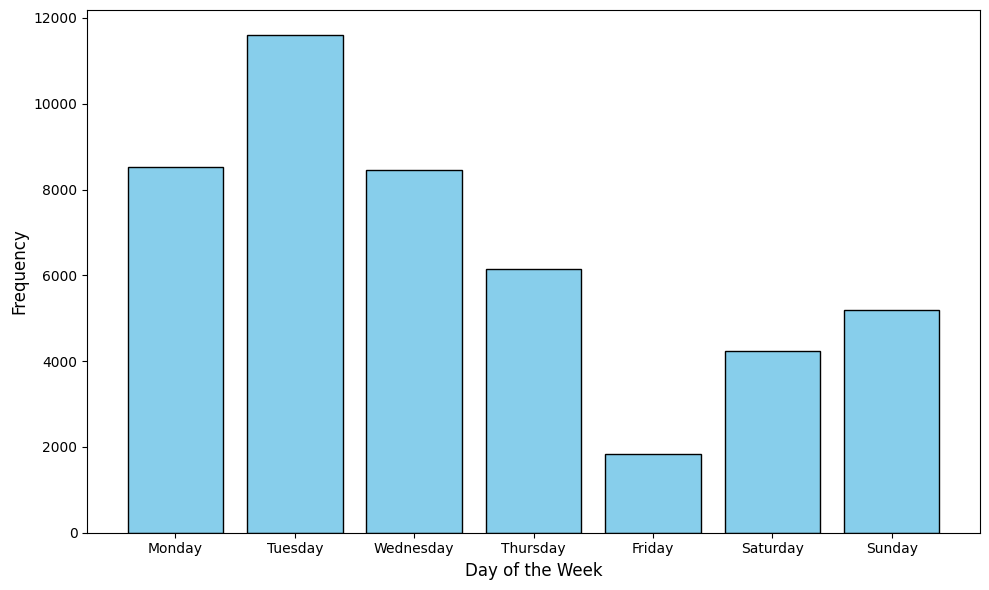

In [115]:
import matplotlib.pyplot as plt

# 요일 순서대로 정렬
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=weekday_order, ordered=True)
df = df.sort_values('day_of_week')

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(df['day_of_week'], df['count'], color='skyblue', edgecolor='black')

# 그래프 제목과 레이블 설정
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 그래프 출력
plt.tight_layout()  # 레이아웃을 조정하여 레이블이 잘리지 않도록 함
plt.show()

## 특정 기간 데이터 가져오기

2025년 1월 데이터만 따로 떼어내는 작업

In [79]:
start_date = '2025-01-01'
end_date = '2025-01-31'

mask = (df['date_time'] >= start_date) & (df['date_time'] <= end_date)
df_feb = df.loc[mask]
df_feb

,date_time,user_name,text,year,month,day,day_of_week,hour
44630,2025-01-01 00:07:00,야림이잉,햅삐뉴이어,2025,1,1,Wednesday,0
44631,2025-01-01 00:07:00,야림이잉,다들 건강하자!!!!,2025,1,1,Wednesday,0
44632,2025-01-01 00:07:00,윤희,앜ㅋㅋㅋ머쓱타트,2025,1,1,Wednesday,0
44633,2025-01-01 00:07:00,윤희,다들 새해 복 많이 받아아아,2025,1,1,Wednesday,0
44634,2025-01-01 00:08:00,윤희,이모티콘,2025,1,1,Wednesday,0
...,...,...,...,...,...,...,...,...
45267,2025-01-16 16:25:00,민지이잉,억울하지도 않아,2025,1,16,Thursday,16
45268,2025-01-16 16:25:00,민지이잉,왜냐면 어차피 한국이여도,2025,1,16,Thursday,16
45269,2025-01-16 16:25:00,민지이잉,"난 수원이기에,,",2025,1,16,Thursday,16
45270,2025-01-16 16:25:00,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,2025,1,16,Thursday,16


## 보낸 사람 정보 전처리

In [80]:
df['user_name'].value_counts()

,count
user_name,
민지이잉,16911
윤희,15860
야림이잉,13214


# 04 카카오톡 메시지 정보 전처리

## 메시지 정보 전처리


###1. 문자열 정보 요약

In [81]:
df['msg_len'] = df['text'].str.len()
df['msg_word_count'] = df['text'].str.split().str.len()

df

,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count
0,2022-01-16 00:02:00,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ,2022,1,16,Sunday,0,20,1
1,2022-01-16 00:02:00,민지이잉,다들 잘쟈!!!,2022,1,16,Sunday,0,8,2
2,2022-01-16 00:04:00,윤희,구랭,2022,1,16,Sunday,0,2,1
3,2022-01-16 00:04:00,윤희,잘쟈,2022,1,16,Sunday,0,2,1
4,2022-01-16 00:04:00,윤희,이모티콘,2022,1,16,Sunday,0,4,1
...,...,...,...,...,...,...,...,...,...,...
45980,2025-03-05 14:22:00,민지이잉,다같이 모여서 피씨방 가쟈><,2025,3,5,Wednesday,14,16,4
45981,2025-03-05 14:41:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1
45982,2025-03-05 14:42:00,민지이잉,이모티콘,2025,3,5,Wednesday,14,4,1
45983,2025-03-05 14:48:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1


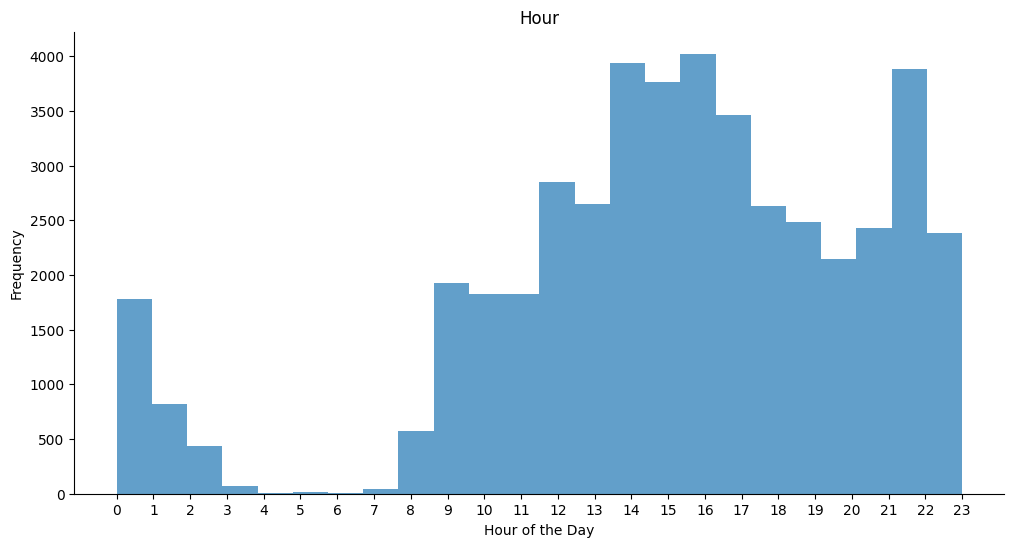

In [82]:
from matplotlib import pyplot as plt

# 그래프 크기 설정 (너비, 높이)
plt.figure(figsize=(12, 6))  # 너비 12, 높이 6으로 설정

# 1시간 단위로 시간을 x축에 표시
df['hour'].plot(kind='hist', bins=24, alpha=0.7, title='Hour')

# x축에 1시간 단위로 레이블 추가
plt.xticks(range(0, 24))  # 0부터 23까지의 시간을 표시

# 상단, 오른쪽 테두리 제거
plt.gca().spines[['top', 'right']].set_visible(False)

# x축과 y축 레이블 추가
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

###2. 사진, 동영상 정보 추출하기

In [83]:
audio_visual_text = '^동영상$|^사진$|^사진 [0-9]{1,2}장$'
mask = df['text'].str.contains(audio_visual_text)
df.loc[mask, 'audio_visual'] = 1
df.loc[~mask, 'audio_visual'] = 0

df.loc[mask, 'msg_len'] = 0
df.loc[mask, 'msg_word_count'] = 0
df[df['audio_visual']==1]

,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count,audio_visual
246,2022-01-18 23:33:00,야림이잉,사진,2022,1,18,Tuesday,23,0,0,1.0
247,2022-01-18 23:51:00,야림이잉,사진,2022,1,18,Tuesday,23,0,0,1.0
248,2022-01-18 23:55:00,민지이잉,사진,2022,1,18,Tuesday,23,0,0,1.0
249,2022-01-18 23:56:00,야림이잉,사진,2022,1,18,Tuesday,23,0,0,1.0
250,2022-01-18 23:58:00,야림이잉,사진,2022,1,18,Tuesday,23,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
45261,2025-01-16 16:05:00,윤희,사진,2025,1,16,Thursday,16,0,0,1.0
45365,2025-03-03 14:14:00,야림이잉,사진,2025,3,3,Monday,14,0,0,1.0
45375,2025-03-03 15:00:00,야림이잉,사진,2025,3,3,Monday,15,0,0,1.0
45460,2025-03-03 20:48:00,민지이잉,사진,2025,3,3,Monday,20,0,0,1.0


###3. 통화 정보 추출하기

In [84]:
df[df['text'].str.contains('보이스톡|페이스톡')]

,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count,audio_visual
496,2022-01-19 21:27:00,민지이잉,보이스톡 해요,2022,1,19,Wednesday,21,7,2,0.0
497,2022-01-19 21:28:00,윤희,보이스톡 해요,2022,1,19,Wednesday,21,7,2,0.0
498,2022-01-19 21:28:00,민지이잉,보이스톡 부재중,2022,1,19,Wednesday,21,8,2,0.0
499,2022-01-19 21:28:00,민지이잉,보이스톡 해요,2022,1,19,Wednesday,21,7,2,0.0
500,2022-01-19 21:28:00,윤희,보이스톡 0:27,2022,1,19,Wednesday,21,9,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
33664,2022-10-18 16:13:00,민지이잉,보이스톡 4:06,2022,10,18,Tuesday,16,9,2,0.0
42284,2023-01-09 19:27:00,윤희,보이스톡 해요,2023,1,9,Monday,19,7,2,0.0
42286,2023-01-09 19:31:00,윤희,보이스톡 4:26,2023,1,9,Monday,19,9,2,0.0
42303,2023-01-09 19:35:00,윤희,페이스톡 해요,2023,1,9,Monday,19,7,2,0.0


text에 보이스톡|페이스톡이 포함된 대화 내용일 수도 있으니 보이스톡|페이스톡 추출

get_call_length 함수를 만들어서 통화 길이 추출



In [85]:
def get_call_length(call_df):

    call_mask = call_df.text.str.contains('해요|취소|부재중|응답없음')            # 0  통화 여부 체크
    call_df = call_df.text.str.extract('([0-9]{1,2}:)*([0-9]{1,2}):([0-9]{2})')   # 1  시:분:초 만 추출
    call_df[0] = call_df[0].str.replace(':', '')                                  # 2  시에 있는 : 제거
    call_df[0] = call_df[0].astype(float).fillna(0)                               # 3  시에 있는 NaN -> 0
    call_df = call_df.astype(float)                                               # 4  문자열을 숫자로
    call_df['call_len'] = call_df[0] * 3660 + call_df[1] * 60 + call_df[2]        # 5  시:분:초를 모두 초로 변경 후 'call_len'열을 ㅁ나들어 넣어줌
    call_df.loc[call_mask, 'call_len'] = 0                                        # 6  call_len 열 값들을 call_mask True는 0으로 변경. False는 그대로 둠

    return call_df[['call_len']]                                                  # 7  call_len 열만 선택

call_col_dict = {
    '페이스톡|Video Call': 'facetalk',
    '보이스톡|Voice Call': 'voicetalk',
}


for call in call_col_dict:
    mask = df['text'].str.contains(call)
    call_df = get_call_length(df[mask])
    call_df = call_df.rename(columns={'call_len': call_col_dict[call]})
    call_df.head()

    df = pd.concat([df, call_df], axis=1)

mask = (df['voicetalk'] >= 0) | (df['facetalk'] >= 0)
df.loc[mask, 'msg_len'] = 0
df.loc[mask, 'msg_word_count'] = 0

df[df['text'].str.contains('보이스톡|페이스톡')]

,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count,audio_visual,facetalk,voicetalk
496,2022-01-19 21:27:00,민지이잉,보이스톡 해요,2022,1,19,Wednesday,21,0,0,0.0,NaN,0.0
497,2022-01-19 21:28:00,윤희,보이스톡 해요,2022,1,19,Wednesday,21,0,0,0.0,NaN,0.0
498,2022-01-19 21:28:00,민지이잉,보이스톡 부재중,2022,1,19,Wednesday,21,0,0,0.0,NaN,0.0
499,2022-01-19 21:28:00,민지이잉,보이스톡 해요,2022,1,19,Wednesday,21,0,0,0.0,NaN,0.0
500,2022-01-19 21:28:00,윤희,보이스톡 0:27,2022,1,19,Wednesday,21,0,0,0.0,NaN,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33664,2022-10-18 16:13:00,민지이잉,보이스톡 4:06,2022,10,18,Tuesday,16,0,0,0.0,NaN,246.0
42284,2023-01-09 19:27:00,윤희,보이스톡 해요,2023,1,9,Monday,19,0,0,0.0,NaN,0.0
42286,2023-01-09 19:31:00,윤희,보이스톡 4:26,2023,1,9,Monday,19,0,0,0.0,NaN,266.0
42303,2023-01-09 19:35:00,윤희,페이스톡 해요,2023,1,9,Monday,19,0,0,0.0,0.0,NaN


### 04. 비언어 표현 추출하기

이모지(emoji)를 추출해내는 emoji 라이브러리 설치

In [86]:
!pip install emoji

emoji 라이브러리를 import 한 후에 주어진 텍스트에 포함되어 있는 모든 이모지를 뽑아 리스트로 반환하는 함수

In [87]:
import emoji

def extract_emojis(text):
    emoji_list = list()
    for e in emoji.emoji_list(text):  # Use emoji_list to extract emojis
        emoji_list.append(e['emoji'])
    return emoji_list

# Example nonverbal regex patterns
mimetic = "[ㅋㅎㅠㅜ!?~]+"
punctuations = "[,.]{2,}"
emo_type1_facial1 = "[;:]{1}[\^\'-]?[)(DPpboOX]"
emo_type1_facial2 = "[>ㅜㅠㅡ@\^][ㅁㅇ0oO\._\-]*[\^ㅜㅠㅡ@<];*"
emo_type3 = "\(.+?\)"

nonverbal_list = [mimetic, punctuations, emo_type1_facial1, emo_type1_facial2, emo_type3]

# Assuming df is a pandas DataFrame with a 'text' column
df['nonverbal'] = df['text'].str.findall('|'.join(nonverbal_list)) + df['text'].map(extract_emojis)
df['nonverbal_count'] = df['nonverbal'].apply(len)
df.loc[df['nonverbal_count'] > 0]


,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count,audio_visual,facetalk,voicetalk,nonverbal,nonverbal_count
0,2022-01-16 00:02:00,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ,2022,1,16,Sunday,0,20,1,0.0,NaN,NaN,"[ㅋㅋㅋㅋㅋㅋㅋㅋ, ㅋㅋㅋㅋㅋ, ㅋㅋ]",3
1,2022-01-16 00:02:00,민지이잉,다들 잘쟈!!!,2022,1,16,Sunday,0,8,2,0.0,NaN,NaN,[!!!],1
11,2022-01-16 23:11:00,윤희,ㅎㅎㅎㅎ,2022,1,16,Sunday,23,4,1,0.0,NaN,NaN,[ㅎㅎㅎㅎ],1
13,2022-01-16 23:12:00,윤희,초밥만 파나??,2022,1,16,Sunday,23,8,2,0.0,NaN,NaN,[??],1
14,2022-01-16 23:12:00,야림이잉,앜ㅋㅋㅋㅋㅋㅋㅋㅋ,2022,1,16,Sunday,23,9,1,0.0,NaN,NaN,[ㅋㅋㅋㅋㅋㅋㅋㅋ],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45968,2025-03-05 14:20:00,윤희,ㅋㅋㅋㅋㅋㅋ,2025,3,5,Wednesday,14,6,1,0.0,NaN,NaN,[ㅋㅋㅋㅋㅋㅋ],1
45970,2025-03-05 14:20:00,민지이잉,"ㅋ큐큨 재밋지,,,,,",2025,3,5,Wednesday,14,12,2,0.0,NaN,NaN,"[ㅋ, ,,,,,]",2
45978,2025-03-05 14:21:00,윤희,ㅋㅋㅋㅋㅋㅋㅋㅋ,2025,3,5,Wednesday,14,8,1,0.0,NaN,NaN,[ㅋㅋㅋㅋㅋㅋㅋㅋ],1
45980,2025-03-05 14:22:00,민지이잉,다같이 모여서 피씨방 가쟈><,2025,3,5,Wednesday,14,16,4,0.0,NaN,NaN,[><],1


### 05. URL 추출하기

URL을 추출하는 urlextract 라이브러리 설치

In [88]:
!pip install urlextract

In [89]:
from urlextract import URLExtract

text = """Google Colab: https://colab.research.google.com.
       Introduction for google colab: https://colab.research.google.com/notebooks/intro.ipynb"""

extractor = URLExtract()
urls = extractor.find_urls(text)

for url in urls:
    print(url)

https://colab.research.google.com
https://colab.research.google.com/notebooks/intro.ipynb


In [90]:
from urlextract import URLExtract


extractor = URLExtract()

df['url'] = df['text'].apply(extractor.find_urls)
df


,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count,audio_visual,facetalk,voicetalk,nonverbal,nonverbal_count,url
0,2022-01-16 00:02:00,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ,2022,1,16,Sunday,0,20,1,0.0,NaN,NaN,"[ㅋㅋㅋㅋㅋㅋㅋㅋ, ㅋㅋㅋㅋㅋ, ㅋㅋ]",3,[]
1,2022-01-16 00:02:00,민지이잉,다들 잘쟈!!!,2022,1,16,Sunday,0,8,2,0.0,NaN,NaN,[!!!],1,[]
2,2022-01-16 00:04:00,윤희,구랭,2022,1,16,Sunday,0,2,1,0.0,NaN,NaN,[],0,[]
3,2022-01-16 00:04:00,윤희,잘쟈,2022,1,16,Sunday,0,2,1,0.0,NaN,NaN,[],0,[]
4,2022-01-16 00:04:00,윤희,이모티콘,2022,1,16,Sunday,0,4,1,0.0,NaN,NaN,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,2025-03-05 14:22:00,민지이잉,다같이 모여서 피씨방 가쟈><,2025,3,5,Wednesday,14,16,4,0.0,NaN,NaN,[><],1,[]
45981,2025-03-05 14:41:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1,0.0,NaN,NaN,[],0,[]
45982,2025-03-05 14:42:00,민지이잉,이모티콘,2025,3,5,Wednesday,14,4,1,0.0,NaN,NaN,[],0,[]
45983,2025-03-05 14:48:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1,0.0,NaN,NaN,[],0,[]


In [91]:
df['url_count'] = df['url'].apply(len)
url_df = df.loc[df['url_count'] > 0]
url_df[['date_time','user_name','url','url_count']]

,date_time,user_name,url,url_count
15,2022-01-16 23:12:00,야림이잉,[https://place.map.kakao.com/m/132421638#photo...,1
240,2022-01-18 22:46:00,민지이잉,[http://naver.me/Gc4hUWqP],1
242,2022-01-18 23:15:00,야림이잉,[http://www.dndshop.co.kr/?sd=3&sc=3_2],1
243,2022-01-18 23:18:00,민지이잉,[http://www.boardbox.co.kr/shop/],1
244,2022-01-18 23:19:00,민지이잉,[http://naver.me/IMxLfA95],1
386,2022-01-19 16:20:00,야림이잉,[http://theamall.com/product/231837],1
2877,2022-01-30 00:47:00,민지이잉,[https://youtube.com/shorts/6Ce4zBRc7qE?featur...,1
5290,2022-02-16 13:39:00,야림이잉,[https://link.coupang.com/re/NONPROFITSDP?lpta...,1
5291,2022-02-16 13:39:00,야림이잉,[https://link.coupang.com/re/NONPROFITSDP?lpta...,1
5319,2022-02-16 13:42:00,윤희,[https://ohouse.onelink.me/2107755860/fbc1dee3],1


#05. 가공한 데이터 저장하기

## 데이터 프레임 파일로 저장하고 불러오기

In [92]:
import os
import pandas as pd

f_path = '/content/drive/MyDrive/Katalk_data_analysis/'
f_name = 'data_tmp.csv'

df3 = pd.DataFrame({'B': ['a', 'c', 'b', 'd'],
                     'C': [3, 6, 9, 0],
                     'D': ['b', 'b', 'e', 'a']})

df3.to_csv(os.path.join(f_path, f_name), index=False)

In [93]:
df3.to_excel(os.path.join(f_path, "data_tmp.xlsx"), index=False)

저장된 파일 불러오기

In [94]:
pd.read_csv(os.path.join(f_path, 'data_tmp.csv'))

,B,C,D
0,a,3,b
1,c,6,b
2,b,9,e
3,d,0,a


In [95]:
pd.read_excel(os.path.join(f_path, 'data_tmp.xlsx'))

,B,C,D
0,a,3,b
1,c,6,b
2,b,9,e
3,d,0,a


## 가공한 카카오톡 데이터 파일로 저장하고 불러오기

### 엑셀 파일로 저장하기

In [96]:
df.to_excel(os.path.join(f_path, 'katalk_data_friend.xlsx'), index=False)

### 엑셀 파일 불러오기

In [97]:
import os
import pandas as pd

f_path = '/content/drive/MyDrive/Katalk_data_analysis/'
df_excel = pd.read_excel(os.path.join(f_path, 'katalk_data_friend.xlsx'))

df_excel

,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count,audio_visual,facetalk,voicetalk,nonverbal,nonverbal_count,url,url_count
0,2022-01-16 00:02:00,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ,2022,1,16,Sunday,0,20,1,0,NaN,NaN,"['ㅋㅋㅋㅋㅋㅋㅋㅋ', 'ㅋㅋㅋㅋㅋ', 'ㅋㅋ']",3,[],0
1,2022-01-16 00:02:00,민지이잉,다들 잘쟈!!!,2022,1,16,Sunday,0,8,2,0,NaN,NaN,['!!!'],1,[],0
2,2022-01-16 00:04:00,윤희,구랭,2022,1,16,Sunday,0,2,1,0,NaN,NaN,[],0,[],0
3,2022-01-16 00:04:00,윤희,잘쟈,2022,1,16,Sunday,0,2,1,0,NaN,NaN,[],0,[],0
4,2022-01-16 00:04:00,윤희,이모티콘,2022,1,16,Sunday,0,4,1,0,NaN,NaN,[],0,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,2025-03-05 14:22:00,민지이잉,다같이 모여서 피씨방 가쟈><,2025,3,5,Wednesday,14,16,4,0,NaN,NaN,['><'],1,[],0
45981,2025-03-05 14:41:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1,0,NaN,NaN,[],0,[],0
45982,2025-03-05 14:42:00,민지이잉,이모티콘,2025,3,5,Wednesday,14,4,1,0,NaN,NaN,[],0,[],0
45983,2025-03-05 14:48:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1,0,NaN,NaN,[],0,[],0


In [98]:
print(type(df_excel.at[0, 'nonverbal']))

<class 'str'>


###피클(pickle)로 저장하기

In [99]:
df.to_pickle(os.path.join(f_path, "katalk_data_friend.pkl"))

###피클(pickle)파일로 저장된 데이터 프레임 읽어오기

In [100]:
import os
import pandas as pd

f_path = '/content/drive/MyDrive/Katalk_data_analysis/'

df = pd.read_pickle(os.path.join(f_path, "katalk_data_friend.pkl"))

df

,date_time,user_name,text,year,month,day,day_of_week,hour,msg_len,msg_word_count,audio_visual,facetalk,voicetalk,nonverbal,nonverbal_count,url,url_count
0,2022-01-16 00:02:00,민지이잉,ㅋㅋㅋㅋㅋㅋㅋㅋㄱㅇㄱㅋㅋㅋㅋㅋ진짴ㅋㅋ,2022,1,16,Sunday,0,20,1,0.0,NaN,NaN,"[ㅋㅋㅋㅋㅋㅋㅋㅋ, ㅋㅋㅋㅋㅋ, ㅋㅋ]",3,[],0
1,2022-01-16 00:02:00,민지이잉,다들 잘쟈!!!,2022,1,16,Sunday,0,8,2,0.0,NaN,NaN,[!!!],1,[],0
2,2022-01-16 00:04:00,윤희,구랭,2022,1,16,Sunday,0,2,1,0.0,NaN,NaN,[],0,[],0
3,2022-01-16 00:04:00,윤희,잘쟈,2022,1,16,Sunday,0,2,1,0.0,NaN,NaN,[],0,[],0
4,2022-01-16 00:04:00,윤희,이모티콘,2022,1,16,Sunday,0,4,1,0.0,NaN,NaN,[],0,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,2025-03-05 14:22:00,민지이잉,다같이 모여서 피씨방 가쟈><,2025,3,5,Wednesday,14,16,4,0.0,NaN,NaN,[><],1,[],0
45981,2025-03-05 14:41:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1,0.0,NaN,NaN,[],0,[],0
45982,2025-03-05 14:42:00,민지이잉,이모티콘,2025,3,5,Wednesday,14,4,1,0.0,NaN,NaN,[],0,[],0
45983,2025-03-05 14:48:00,윤희,이모티콘,2025,3,5,Wednesday,14,4,1,0.0,NaN,NaN,[],0,[],0


In [101]:
print(type(df_excel.at[0, 'nonverbal']))

<class 'str'>
